LDA Accuracy = 97.0
QDA Accuracy = 96.0


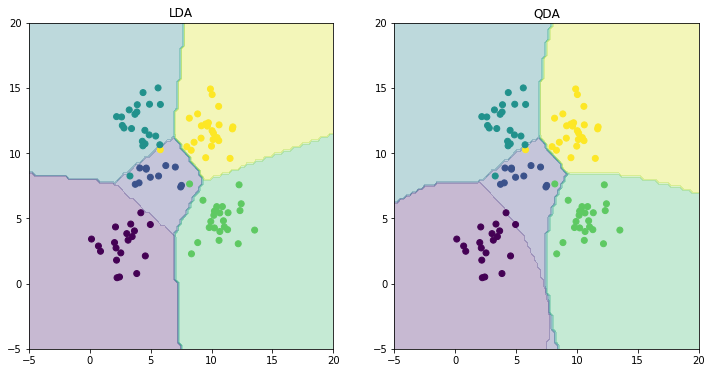

In [45]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
import sys

def ldaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix
    # IMPLEMENT THIS METHOD
    k = (np.unique(y)).size
    d = np.shape(X)[1]
    mean = np.empty((d, k))
    covmat = np.empty((d,d))
    for i in range (1, k + 1):
        classIndex = np.where(y==i)[0]
        classData = X[classIndex,:]
        mean[:, i-1] = np.mean(classData, axis=0).transpose()
    covmat = np.cov(X.T)

    return mean,covmat

def qdaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes

    # IMPLEMENT THIS METHOD
    k = (np.unique(y)).size
    d = np.shape(X)[1]
    mean = np.empty((d, k))
    covmats = []
    for i in range (1, k+1):
        classIndex = np.where(y==i)[0]
        classData = X[classIndex,:]
        mean[:, i-1] = np.mean(classData, axis=0).transpose()
        covmats.append(np.cov(np.transpose(classData)))

    return mean,covmats

def ldaTest(means,covmat,Xtest,ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    N = np.shape(Xtest)[0]
    classCount = np.shape(means)[1]
    ypred = np.empty((N, 1))
    incorrect = 0.0
    invCov = np.linalg.inv(covmat)
    #print invCov
    ytest = ytest.astype(int)
    for i in range (1, N + 1):
        pdf = 0
        predict_class = 0
        testX = np.transpose(Xtest[i-1,:])
        for j in range (1, classCount+1):
            result_pdf = np.exp((-1/2)*np.dot(np.dot(np.transpose(testX - means[:, j-1]),invCov),(testX - means[:, j-1])))
            if (result_pdf > pdf):
                predict_class = j
                ypred[i-1,:] = j;
                pdf = result_pdf
        if (predict_class != ytest[i-1]):
            incorrect = incorrect + 1
    accuracy = (N - incorrect)/N
    return accuracy*100,ypred

def qdaTest(means,covmats,Xtest,ytest):
    # Inputs
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    '''classCount = np.shape(means)[1]
    d = np.shape(Xtest)[1]
    N = np.shape(Xtest)[0]

    temp = np.empty((N,classCount))
    predict_class = np.empty((N,1))

    incorrect = 0.0
    covmat_array = np.array(covmats)
    for i in range(0,classCount):
        for j in range(0,N):
            p = np.dot(np.dot(Xtest[j,:]-np.transpose(means[:,i]),np.linalg.inv(covmat_array[i])),(Xtest[j,:]-np.transpose(means[:,i])))
            temp[j,i] = 1/(2*pi)*np.sqrt(np.linalg.det(covmat_array[i])) * np.exp(p)

    predict_class = (np.argmin(temp,axis=1)) + 1

    for i in range(0,N):
        if(ytest[i] != predict_class[i]):
            incorrect = incorrect + 1
    ypred = predict_class.reshape(Xtest.shape[0],1)
    accuracy = (N - incorrect)/N
    return accuracy*100,ypred'''
    ypred = np.zeros((len(Xtest)))
    pred = np.zeros((len(means.T)), dtype=np.ndarray)

    i = 0
    count = 0.0

    for x in Xtest:
        #for mean in means.T:
        for j in range (0,len(means.T)):
            mean = means.T[j]
            covmat = covmats[j]
            x_sub_mu = np.subtract(x, mean)
            cov_inv = np.linalg.inv(covmat)
            cov_det = np.linalg.det(covmat)
            pred[j] = np.exp(-0.5 * np.dot(np.dot(x_sub_mu,cov_inv).T,x_sub_mu)) / np.power(cov_det,0.5)
        ypred[i] = np.argmax(pred) + 1
        if ypred[i] == ytest[i][0]:
            count = count + 1
        i = i + 1
    acc = (count/len(ytest)) * 100
    return acc,ypred


# Main script

# Problem 1
# load the sample data                                                                 
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')

# LDA
means,covmat = ldaLearn(X,y)
ldaacc,ldares = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))
means,covmats = qdaLearn(X,y)
qdaacc,qdares = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))

# plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.flatten())
plt.title('LDA')

plt.subplot(1, 2, 2)

zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.flatten())
plt.title('QDA')

plt.show()


In [7]:
np.shape([[1, 2]])[0]

1

In [9]:
import numpy as np


a = [[0, 1],[2, 3]]

print (a[0])
testX1 = np.transpose(a[0])
print testX1   
     
X = np.array([[1,2,3],[4,5,6]])
X.T

[0, 1]
[0 1]


array([[1, 4],
       [2, 5],
       [3, 6]])